In [8]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.widgets import Slider, Button

import astropy.units as u
import astropy.constants as const
from astropy.time import Time
from astropy.coordinates import EarthLocation, Angle

from scipy.signal.windows import tukey


import time as timer
from interactions_funcs import *

%matplotlib nbagg

## Import screens 

In [9]:
import sys
sys.path.append('/home/montalvo/Pyspace/Scintillometry/scint_dp/')


from screenpkg.screens.screen import Source, Screen1D, Telescope
from screenpkg.screens.fields import phasor
from screenpkg.screens.visualization import axis_extent

## Set pulsar paramters and observation

In [10]:
# Pulsar params
#PSRB1508+55

#distance
d_p = 2100. * u.pc
PMRA = -73.64 * u.mas / u.year
PMDEC = -62.65 * u.mas / u.year


#observation params
mjds = 53295.


psrname = 'PSRB1508+55'
telescope = EarthLocation.from_geodetic(Angle('6°52′58″'),Angle('50°31′29″'),height=319.) #Effelsberg


#frequency (MHz)
freq0 = 1350
#bandwith (MHz)
bandwidth = 100 
#number of frequency channels
freq_N = 1024 * 4

#create observation frequency array
freq = np.linspace(freq0 - bandwidth, freq0 + bandwidth, freq_N) * u.MHz

#Earth terms
vtel_vec = get_vearth(psrname, mjds) 
vearth = np.sqrt( np.dot(vtel_vec, vtel_vec ) )
e_angle = np.arctan2(vtel_vec[1] , vtel_vec[0]).to(u.deg)

#Pulsar terms
vpsr_init = ( d_p * np.sqrt( PMDEC**2 + PMRA**2)  / u.rad ).to(u.km / u.s)
dp_angle_init = np.arctan2( PMDEC , PMRA ).to(u.deg)

## Set the parameters for the two screens

In [11]:
#distance, orientation (East of North) and transverse velocity for screen 1
d_s1_init = 127 * u.pc 
xi1_init = 53*u.deg 
v1_init = 7.3*u.km/u.s 


#distance, orientation (East of North) and transverse velocity for screen 2
d_s2_init = 1935*u.pc
xi2_init = 129.7 *u.deg
v2_init = -6*u.km/u.s

## Create and modify the wavefield (interactively)

<IPython.core.display.Javascript object>


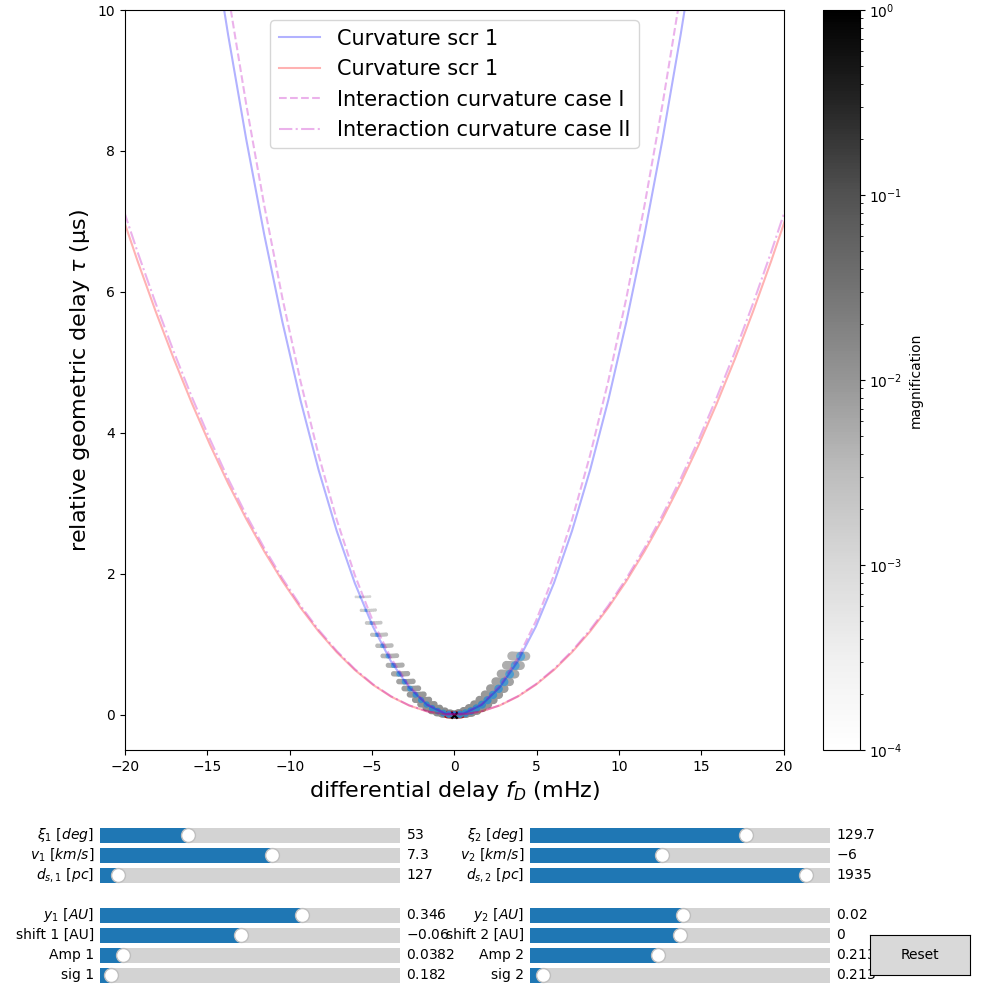

0

In [12]:
#number of points for screen 1 and screen 2
N1 = 30
N2 = 8

#initial shift of the points in AU 
shift1_init = -0.06
shift2_init = 0.

#unit variables
tau_unit = u.us
taudot_unit = u.us/u.day

#scale factors that control the physical scale of the 1d screens
#they are just multipliers applied to the scales of 1AU 1d screens
#for instance scr2_init = 0.1 implies the screen spans -0.1 AU to 0.1 AU
scr1_init = 0.346
scr2_init = 0.02
taudot_arr = np.linspace(-7,7,200) * u.us * u.day**-1

#amplitudes and sigma
Amp1_init = 0.0382
Amp2_init = 0.213

sig1_init = 0.182
sig2_init = 0.213

fd_max = 20
tau_max = 10



#getting a curvature for the first screen
eta1, ddeff1, dveff1 = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = d_s1_init, 
                    xi1 = xi1_init, 
                    v1 = v1_init, 
                    freq = np.mean(freq),
                    extra_info = True)


#getting a curvature for the second screen
eta2, ddeff2, dveff2 = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = d_s2_init, 
                    xi1 = xi2_init, 
                    v1 = v2_init, 
                    freq = np.mean(freq),
                    extra_info = True)


eta_int1, eta_int2, _, _, diveff1, _  = interaction_arcs(d_p = d_p, 
                                        vpsr = vpsr_init, 
                                        dp_angle = dp_angle_init, 
                                        vearth = vearth, 
                                        e_angle = e_angle, 
                                        ds1 = d_s1_init, 
                                        xi1 = xi1_init, 
                                        v1 = v1_init, 
                                        ds2 = d_s2_init, 
                                        xi2 = xi2_init, 
                                        v2 = v2_init, 
                                        freq = np.mean(freq))




#Getting details of the scattering geometry, where 
#obs0: line of sight path
#obs1: pulsar -> screen 1 -> Earth
#obs2: pulsar -> screen 2 -> Earth
#Obs12: pulsar -> screen 2 -> screen 1 -> Earth
obs0, obs1, obs2, obs12, los_fac = observations(xi1=xi1_init, v1=v1_init,
                                                 xi2=xi2_init, v2=v2_init,
                                                 vpsr=vpsr_init, dp_angle=dp_angle_init,
                                                 scr1_scale = scr1_init, scr2_scale = scr2_init,
                                                 d_s1 = d_s1_init, d_s2 = d_s2_init, 
                                                 Amp1 = Amp1_init, Amp2 = Amp2_init,
                                                 sig1 = sig1_init, sig2 = sig2_init,
                                                 shift1 = shift1_init, shift2 = shift2_init,
                                                 N1 = N1, N2 = N2,
                                                 d_p = d_p, vearth = vearth, e_angle = e_angle
                                               )
all_obs = obs0, obs1, obs2, obs12
brightness = np.hstack([obs.brightness.ravel() * los_fac for obs in all_obs])
mall = np.abs(brightness)
# assert np.isclose(np.sum(np.abs(brightness)**2), 1.)

fig, ax = plt.subplots(figsize=(10., 10.), dpi = 100)
    

scs = []
npoints = obs1.tau.shape[0]
#Adjust the sizes of the points on screen 1 (only to identify where each double scattered image comes from)
sizes = np.linspace(1, 30, npoints)  # 30 → 5, adjust as you like



for obs, marker, cmap in (
        (obs0, "x", "Greys"),
        (obs1, "o", "Blues"),
        (obs2, "o", "Reds"),
        (obs12, "o", "Greys"))[::-1]:

    tau = obs.tau.to_value(tau_unit).ravel()
    taudot = obs.taudot.to_value(taudot_unit).ravel() * (
        u.us * u.day**-1 * np.mean(freq)
    ).to(u.mHz).value

    if obs is obs1:
        # assign one size per obs1 point
        point_sizes = sizes
    elif obs is obs12:
        # repeat each obs1 size for the 10 points in obs12
        tau = tau
        taudot = taudot
        
        point_sizes = np.repeat(sizes, obs.tau.shape[1])  # shape (60*10,)
        sc = ax.scatter(taudot, tau, marker=marker, s=point_sizes,
                    c=np.abs(obs.brightness).ravel(), cmap=cmap,
                    norm=LogNorm(vmin=mall.min()*0.1, vmax=mall.max()))
    else:
        # constant size for other obs
        point_sizes = 20
        
    if obs != obs12:
        sc = ax.scatter(taudot, tau, marker=marker, s=point_sizes,
                    c=np.abs(obs.brightness).ravel(), cmap=cmap,
                    norm=LogNorm(vmin=1e-4, vmax=1))
    
    
    scs.insert(0, sc)


fig.colorbar(mappable=sc, label="magnification", fraction=0.1)

ax.set_xlabel(rf"differential delay $f_D$ (mHz)", fontsize = 16)
ax.set_ylabel(rf"relative geometric delay $\tau$ ({tau_unit:latex_inline})", fontsize = 16)

line1, = ax.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta1).to(u.us), c = 'b', alpha = 0.3 , label = 'Curvature scr 1')
line2, = ax.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta2).to(u.us), c = 'r', alpha = 0.3 , label = 'Curvature scr 1')

#interaction arc curvature for case I
line3, = ax.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int1).to(u.us), '--' ,c = 'm', alpha = 0.3, label = 'Interaction curvature case I'  )
#interaction arc curvature for case II
line4, = ax.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int2).to(u.us), '-.' ,c = 'm', alpha = 0.3, label = 'Interaction curvature case II'  )



ax.set_ylim(-0.5,tau_max)
ax.set_xlim(-fd_max,fd_max)
ax.legend(fontsize = 15)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(bottom = 0.25, top = 0.99)
# Make a horizontal slider to control the frequency.


dy = -0.05


ax_xi1 = fig.add_axes([0.1, 0.2 + dy , 0.3, 0.03])
xi1_slider = Slider(ax=ax_xi1, label=r'$\xi_{1}~[deg]$',
                    valmin=0., valmax=180, valinit=xi1_init.to_value(u.deg))

ax_xi2 = fig.add_axes([0.53, 0.2 + dy , 0.3, 0.03])
xi2_slider = Slider(ax=ax_xi2, label=r'$\xi_{2}~[deg]$',
                    valmin=0., valmax=180, valinit=xi2_init.to_value(u.deg))


ax_v1 = fig.add_axes([0.1, 0.18 + dy , 0.3, 0.03])
v1_slider = Slider(ax=ax_v1, label=r'$v_{1}~[km/s]$',
                   valmin=-50., valmax=50, valinit=v1_init.value)

ax_v2 = fig.add_axes([0.53, 0.18 + dy , 0.3, 0.03])
v2_slider = Slider(ax=ax_v2, label=r'$v_{2}~[km/s]$',
                   valmin=-50., valmax=50, valinit=v2_init.value)


ax_ds1 = fig.add_axes([0.1, 0.16 + dy , 0.3, 0.03])
ds1_slider = Slider(ax=ax_ds1, label=r'$d_{s,1}~[pc]$',
                     valmin=0., valmax=d_p.value, valinit=d_s1_init.to_value(u.pc))

ax_ds2 = fig.add_axes([0.53, 0.16 + dy , 0.3, 0.03])
ds2_slider = Slider(ax=ax_ds2, label=r'$d_{s,2}~[pc]$',
                     valmin=0., valmax=d_p.value, valinit=d_s2_init.to_value(u.pc))




ax_scr1 = fig.add_axes([0.1, 0.12 + dy , 0.3, 0.03])
scr1_slider = Slider(ax=ax_scr1, label=r'$y_1~[AU]$',
                     valmin=-1., valmax=1, valinit=scr1_init)

ax_scr2 = fig.add_axes([0.53, 0.12 + dy , 0.3, 0.03])
scr2_slider = Slider(ax=ax_scr2, label=r'$y_2~[AU]$',
                     valmin=-1., valmax=1., valinit=scr2_init)

ax_shift1 = fig.add_axes([0.1, 0.10 + dy, 0.3, 0.03])
shift1_slider = Slider(ax=ax_shift1, label=r'shift 1 [AU]',
                     valmin=-1., valmax=1, valinit=shift1_init)

ax_shift2 = fig.add_axes([0.53, 0.10 + dy, 0.3, 0.03])
shift2_slider = Slider(ax=ax_shift2, label=r'shift 2 [AU]',
                     valmin=-1., valmax=1, valinit=shift2_init)

ax_Amp1 = fig.add_axes([0.1, 0.08 + dy , 0.3, 0.03])
amp1_slider = Slider(ax=ax_Amp1, label=r'Amp 1',
                     valmin=0., valmax=0.5, valinit=Amp1_init)

ax_Amp2 = fig.add_axes([0.53, 0.08 + dy, 0.3, 0.03])
amp2_slider = Slider(ax=ax_Amp2, label=r'Amp 2',
                     valmin=0., valmax=0.5, valinit=Amp2_init)

ax_sig1 = fig.add_axes([0.1, 0.06  + dy, 0.3, 0.03])
sig1_slider = Slider(ax=ax_sig1, label=r'sig 1',
                     valmin=0., valmax=5, valinit=sig1_init)

ax_sig2 = fig.add_axes([0.53, 0.06 + dy, 0.3, 0.03])
sig2_slider = Slider(ax=ax_sig2, label=r'sig 2',
                     valmin=0., valmax=5, valinit=sig2_init)






def update(val):
    obs0, obs1, obs2, obs12, los_fac = observations(
        xi1=xi1_slider.val * u.deg,
        v1=v1_slider.val * u.km/u.s,
        xi2 = xi2_slider.val * u.deg,
        v2 = v2_slider.val * u.km/u.s,
        vpsr = vpsr_init,
        dp_angle = dp_angle_init,
        scr1_scale = scr1_slider.val,
        scr2_scale = scr2_slider.val,
        d_s1 = ds1_slider.val * u.pc,
        d_s2 = ds2_slider.val * u.pc,
        Amp1 = amp1_slider.val,
        Amp2 = amp2_slider.val,
        sig1 = sig1_slider.val,
        sig2 = sig2_slider.val,
        shift1 = shift1_slider.val,
        shift2 = shift2_slider.val,
        N1 = N1, N2 = N2,
        d_p = d_p, vearth = vearth, e_angle = e_angle
        )
    

    all_obs = obs0, obs1, obs2, obs12
    brightnesses = [obs.brightness.ravel() * los_fac for obs in all_obs]
    
    
    for obs, sc, b in zip(all_obs, scs, brightnesses):
        tau = obs.tau.to_value(tau_unit).ravel()
        taudot = obs.taudot.to_value(taudot_unit).ravel() * (u.us * u.day**-1 * np.mean(freq)).to(u.mHz).value
        
        sc.set_offsets(np.vstack([taudot, tau]).T)

#         Update color intensities
        sc.set_array(np.abs(b.ravel()))  # brightness is already scaled by los_fac
    
    
        
    eta1_new = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = ds1_slider.val * u.pc, 
                    xi1 = xi1_slider.val * u.deg, 
                    v1 = v1_slider.val * u.km/u.s, 
                    freq = np.mean(freq))
    
    eta2_new = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = ds2_slider.val * u.pc, 
                    xi1 = xi2_slider.val * u.deg, 
                    v1 = v2_slider.val * u.km/u.s, 
                    freq = np.mean(freq))
    
    
    eta_int1_new, eta_int2_new, _, _, _, _  = interaction_arcs(d_p = d_p, 
                                        vpsr = vpsr_init, 
                                        dp_angle = dp_angle_init, 
                                        vearth = vearth, 
                                        e_angle = e_angle, 
                                        ds1 = ds1_slider.val * u.pc, 
                                        xi1 = xi1_slider.val * u.deg, 
                                        v1 = v1_slider.val * u.km/u.s, 
                                        ds2 = ds2_slider.val * u.pc, 
                                        xi2 = xi2_slider.val * u.deg, 
                                        v2 = v2_slider.val * u.km/u.s, 
                                        freq = np.mean(freq))
        
        
        
    line1.set_ydata((( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta1_new).to(u.us))
    line2.set_ydata((( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta2_new).to(u.us))
    line3.set_ydata((( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int1_new).to(u.us))
    line4.set_ydata((( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int2_new).to(u.us))




xi1_slider.on_changed(update)
v1_slider.on_changed(update)
xi2_slider.on_changed(update)
v2_slider.on_changed(update)
scr1_slider.on_changed(update)
scr2_slider.on_changed(update)
ds1_slider.on_changed(update)
ds2_slider.on_changed(update)
amp1_slider.on_changed(update)
amp2_slider.on_changed(update)
sig1_slider.on_changed(update)
sig2_slider.on_changed(update)
shift1_slider.on_changed(update)
shift2_slider.on_changed(update)


resetax = fig.add_axes([0.87, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    xi1_slider.reset()
    v1_slider.reset()
    xi2_slider.reset()
    v2_slider.reset()
    vpsr_slider.reset()
    vpa_slider.reset()
    scr1_slider.reset()
    scr2_slider.reset()
    ds1_slider.reset()
    ds2_slider.reset()
    amp1_slider.reset()
    amp2_slider.reset()
    sig1_slider.reset()
    sig2_slider.reset()
    shift1_slider.reset()
    shift2_slider.reset()

button.on_clicked(reset)

## If satisfied with the wavefield, make a dynamic spectrum

In [13]:
## Make a new object for the observations

obs0, obs1, obs2, obs12, los_fac = observations(xi1=xi1_init, v1=v1_init,
                                                 xi2=xi2_init, v2=v2_init,
                                                 vpsr=vpsr_init, dp_angle=dp_angle_init,
                                                 scr1_scale = scr1_init, scr2_scale = scr2_init,
                                                 d_s1 = d_s1_init, d_s2 = d_s2_init, 
                                                 Amp1 = Amp1_init, Amp2 = Amp2_init,
                                                 sig1 = sig1_init, sig2 = sig2_init,
                                                 shift1 = shift1_init, shift2 = shift2_init,
                                                 N1 = N1, N2 = N2,
                                                 d_p = d_p, vearth = vearth, e_angle = e_angle
                                               )
all_obs = obs0, obs1, obs2, obs12
brightness = np.hstack([obs.brightness.ravel() * los_fac for obs in all_obs])
mall = np.abs(brightness)

## Use this cell instead if you want to use the values from the sliders to make a dynamic spectrum:

In [14]:
## Make a new object for the observations

obs0, obs1, obs2, obs12, los_fac = observations(xi1=xi1_slider.val * u.deg,
                                                v1=v1_slider.val * u.km/u.s,
                                                xi2 = xi2_slider.val * u.deg,
                                                v2 = v2_slider.val * u.km/u.s,
                                                vpsr = vpsr_init,
                                                dp_angle = dp_angle_init,
                                                scr1_scale = scr1_slider.val,
                                                scr2_scale = scr2_slider.val,
                                                d_s1 = ds1_slider.val * u.pc,
                                                d_s2 = ds2_slider.val * u.pc,
                                                Amp1 = amp1_slider.val,
                                                Amp2 = amp2_slider.val,
                                                sig1 = sig1_slider.val,
                                                sig2 = sig2_slider.val,
                                                shift1 = shift1_slider.val,
                                                shift2 = shift2_slider.val,
                                                N1 = N1, N2 = N2,
                                                d_p = d_p, vearth = vearth, e_angle = e_angle
                                                                                       )
all_obs = obs0, obs1, obs2, obs12
brightness = np.hstack([obs.brightness.ravel() * los_fac for obs in all_obs])
mall = np.abs(brightness)

In [15]:
#make an observation time array
t = np.linspace(0, 3*u.hour, 600)[:, np.newaxis]

In [16]:
timer2 = timer.time()

tau0 = np.hstack([obs1.tau.ravel(),
                  obs12.tau.ravel(),
                  obs2.tau.ravel(),
              obs0.tau.ravel()])

taudot = np.hstack([obs1.taudot.ravel(),
                    obs12.taudot.ravel(),
                    obs2.taudot.ravel(),
                    obs0.taudot.ravel()])

brightness = np.hstack([obs1.brightness.ravel() *  los_fac,
                        obs12.brightness.ravel() *  los_fac,
                        obs2.brightness.ravel() *  los_fac,
                        obs0.brightness.ravel() *  los_fac])

tau_t = (tau0[:, np.newaxis, np.newaxis]
    + taudot[:, np.newaxis, np.newaxis] * t)

ph = phasor(freq, tau_t, linear_axis = 0)

#make wavefield
dynwave = ph * brightness[:, np.newaxis, np.newaxis]
dynwave = dynwave.sum(0)

#make dynamic spectrum
dynspec = np.abs(dynwave)**2
dynspec /= dynspec.mean()

print('Elapsed time: ', timer.time() - timer2)

Elapsed time:  11.754664182662964


## Add Gaussian noise

In [17]:
noise = np.random.normal(0, 1, dynwave.shape)
dynspec = np.abs(dynwave)**2  + noise * 0.15

## Plot dynamic spectrum

<IPython.core.display.Javascript object>


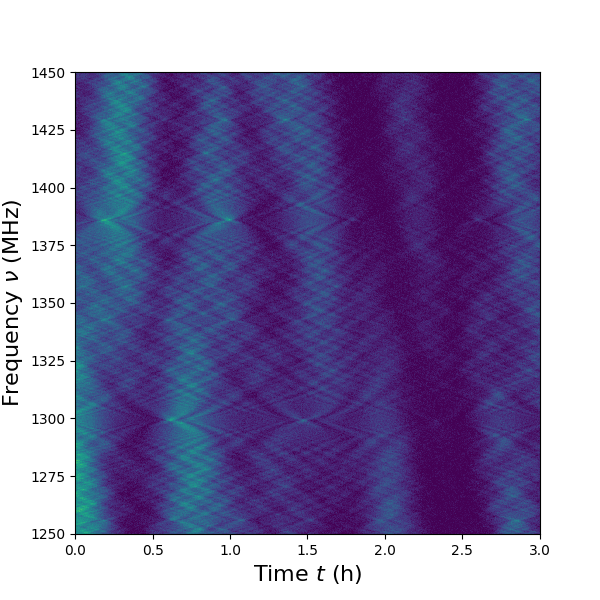

Text(0, 0.5, 'Frequency $\\nu$ (MHz)')

In [18]:
fig, ax_tau = plt.subplots(figsize=(6, 6))

im = ax_tau.imshow(dynspec.T,
           origin='lower', aspect='auto', interpolation='none',
            extent=axis_extent(t, freq), vmin=0, vmax = 6)
ax_tau.set_xlabel(rf"Time $t$ ({t.unit})", fontsize = 16)
ax_tau.set_ylabel(rf"Frequency $\nu$ (MHz)", fontsize = 16)


## Plot secondary spectrum

<IPython.core.display.Javascript object>


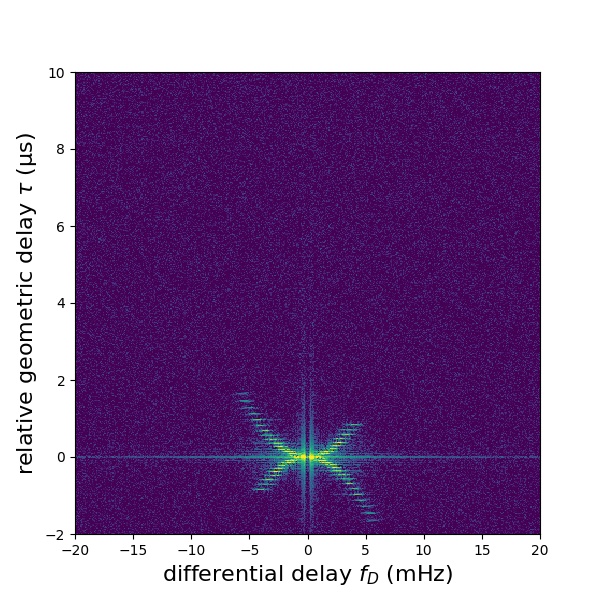

Text(0, 0.5, 'relative geometric delay $\\tau$ ($\\mathrm{\\mu s}$)')

In [19]:
fd_max = 20
tau_max = 10


conjspec = np.fft.fft2(dynspec)
conjspec /= conjspec[0, 0]
conjspec = np.fft.fftshift(conjspec)

tau = np.fft.fftshift(np.fft.fftfreq(freq.size, freq[1]-freq[0])).to(u.us)
fd = np.fft.fftshift(np.fft.fftfreq(t.size, t[1]-t[0])).to(u.mHz)

secspec = np.abs(conjspec)**2


fig, ax_tau = plt.subplots(figsize=(6, 6))
ax_tau.imshow(secspec.T,
       origin='lower', aspect='auto', interpolation='none',
       extent=axis_extent(fd, tau),
       norm=LogNorm(vmin=1.e-8, vmax=5e-5))



ax_tau.set_ylim(-2,tau_max)
ax_tau.set_xlim(-fd_max,fd_max)
ax_tau.set_xlabel(rf"differential delay $f_D$ (mHz)", fontsize = 16)
ax_tau.set_ylabel(rf"relative geometric delay $\tau$ ({tau_unit:latex_inline})", fontsize = 16)

## Smooth edges to reduce peakiness in sec. spectrum

In [20]:
#     Smooth edges to reduce peakiness in sec. spectrum.
alpha_nu = 0.25
alpha_t = 0.35  # Bit larger so nu-t transform also is OK.
taper = (tukey(dynspec.shape[-1], alpha=alpha_nu)
         * tukey(dynspec.shape[0], alpha=alpha_t)[:, np.newaxis])
dynspec = (dynspec - 1.0) * taper + 1.0

<IPython.core.display.Javascript object>


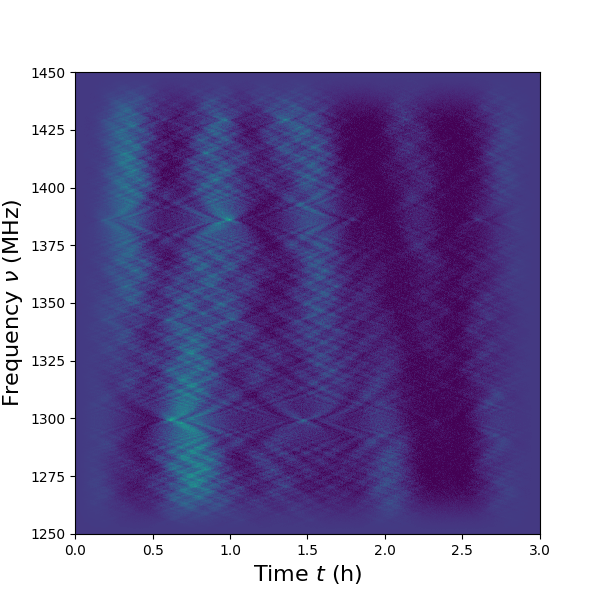

Text(0, 0.5, 'Frequency $\\nu$ (MHz)')

In [21]:
fig, ax_tau = plt.subplots(figsize=(6, 6))

im = ax_tau.imshow(dynspec.T,
           origin='lower', aspect='auto', interpolation='none',
            extent=axis_extent(t, freq), vmin=0, vmax = 6)
ax_tau.set_xlabel(rf"Time $t$ ({t.unit})", fontsize = 16)
ax_tau.set_ylabel(rf"Frequency $\nu$ (MHz)", fontsize = 16)

## Plot secondary spectrum

<IPython.core.display.Javascript object>


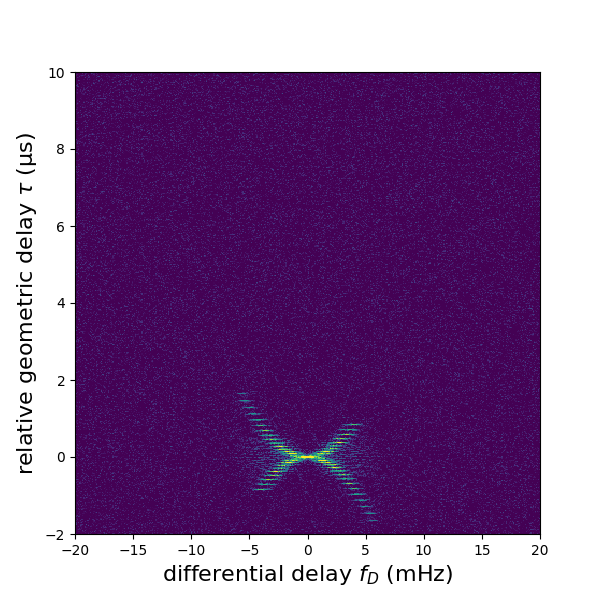

Text(0, 0.5, 'relative geometric delay $\\tau$ ($\\mathrm{\\mu s}$)')

In [22]:
fd_max = 20
tau_max = 10


conjspec = np.fft.fft2(dynspec)
conjspec /= conjspec[0, 0]
conjspec = np.fft.fftshift(conjspec)

tau = np.fft.fftshift(np.fft.fftfreq(freq.size, freq[1]-freq[0])).to(u.us)
fd = np.fft.fftshift(np.fft.fftfreq(t.size, t[1]-t[0])).to(u.mHz)

secspec = np.abs(conjspec)**2


fig, ax_tau = plt.subplots(figsize=(6, 6))
ax_tau.imshow(secspec.T,
       origin='lower', aspect='auto', interpolation='none',
       extent=axis_extent(fd, tau),
       norm=LogNorm(vmin=1.e-8, vmax=5e-5))



ax_tau.set_ylim(-2,tau_max)
ax_tau.set_xlim(-fd_max,fd_max)
ax_tau.set_xlabel(rf"differential delay $f_D$ (mHz)", fontsize = 16)
ax_tau.set_ylabel(rf"relative geometric delay $\tau$ ({tau_unit:latex_inline})", fontsize = 16)